# Solving optimisation problems
## 1. Introduction to optimisation models with JuMP

In [1]:
using JuMP, HiGHS
m = Model(HiGHS.Optimizer)
@variable(m, x₁ >= 0)
@variable(m, x₂ >= 0)
@objective(m, Min, 50x₁ + 70x₂)
@constraint(m, 200x₁ + 2000x₂ >= 9000)
@constraint(m, 100x₁ + 30x₂ >= 300)
@constraint(m, 9x₁ + 11x₂ >= 60)
println(m)

Min 50 x₁ + 70 x₂
Subject to
 200 x₁ + 2000 x₂ ≥ 9000
 100 x₁ + 30 x₂ ≥ 300
 9 x₁ + 11 x₂ ≥ 60
 x₁ ≥ 0
 x₂ ≥ 0



In [2]:
m

A JuMP Model
Minimization problem with:
Variables: 2
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 3 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: x₁, x₂

In [3]:
optimize!(m)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
3 rows, 2 cols, 6 nonzeros
3 rows, 2 cols, 6 nonzeros
Presolve : Reductions: rows 3(-0); columns 2(-0); elements 6(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 3(2205) 0s
          2     3.8814432990e+02 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  3.8814432990e+02
HiGHS run time      :          0.00


In [ ]:
value.([x₁, x₂])

2-element Vector{Float64}:
 1.7010309278350515
 4.329896907216495

## 2. Macros and JuMP performance

In [6]:
using Calculus, AbstractTrees
Meta.parse("(sin(x) + x*x+5x)")

:(sin(x) + x * x + 5x)

In [7]:
print_tree(:(sin(x) + x * x + 5x))

:(sin(x) + x * x + 5x)
├─ :+
├─ :(sin(x))
│  ├─ :sin
│  └─ :x
├─ :(x * x)
│  ├─ :*
│  ├─ :x
│  └─ :x
└─ :(5x)
   ├─ :*
   ├─ 5
   └─ :x


In [8]:
simplify(differentiate(:(sin(x) + x * x + 5x)))

:(5 + cos(x) + (x + x))

## 3. Warehouse transportation optimisation

In [9]:
using DelimitedFiles

In [10]:
S = 18 # warehouses
D = 100 # shops
supply = fill(100, S) # available supply
demand = fill(15, D); # demand

In [11]:
dat = """21328	7901	16774	24413	14131	21551	15742	21091	25167	3266	19312	14878	22914	18392	14514	21072	11535	12965	12952	12952	15839	27836	16816	13527	13769	4924	23891	26532	10245	15446	16834	11421	27231	20285	25810	12477	16499	26958	23770	32327	23572	26475	23894	2054	22156	28491	2392	21051	18793	14598	9413	8004	14286	8717	24919	27581	21829	26135	33450	4905	18558	23046	9212	20923	6426	20020	24644	10862	12351	16446	7751	19819	17406	16768	9319	17584	8191	18776	22432	20389	25377	3129	22425	6899	16830	12305	3393	24579	16727	21086	30660	26999	29664	26436	26138	28183	20874	30143	30419	29718
  5195	15055	4216	9295	6050	4779	3641	15102	8395	16829	5224	3595	14177	1684	2753	4300	5469	4233	3962	3962	3039	13176	12595	4764	5428	12767	7119	11115	6960	1597	1173	5848	26351	10941	19927	7174	13542	11015	6998	18198	18270	9703	7376	15867	21981	12387	19029	6936	9170	15206	7748	8933	11906	12823	24031	21698	8083	11432	18205	18548	17558	25919	10027	7178	10521	19897	29294	15136	13659	10764	18656	7135	9574	19550	13973	11620	17524	10944	9910	9940	26373	13762	11058	16154	22702	19728	14022	13212	4280	7563	22298	13152	15728	12308	17068	19554	12880	16313	18674	20915
  24025	13295	22003	22254	20379	26418	22859	10495	28761	12735	29656	23437	36220	24616	24042	28477	24395	24758	25121	25121	26548	22646	30633	22842	26491	16326	27452	24373	23067	25325	26551	21542	15677	33471	14651	19634	30316	26735	29375	24969	12413	28023	29753	17066	10602	28267	17790	19925	31979	11657	20017	21593	15001	22657	12101	16422	32830	33810	28260	19918	7961	10227	17414	32204	20070	8789	9898	25254	26654	15742	22269	18946	30636	6105	14423	31182	22709	32007	34792	15723	12559	17643	34786	12754	2900	26823	15171	36939	28008	19237	19501	18955	20687	20740	15099	17024	13131	22051	19380	18559
  22508	22014	17954	25593	16490	22230	16922	24989	25524	22994	19299	15807	6155	19098	15443	21468	12730	13765	13698	13698	16518	29016	5152	14712	12407	19272	24570	27712	12077	16125	17442	13516	36239	9317	29815	14836	4483	28138	23911	33506	28157	27086	24005	18712	31869	29670	18413	22231	11140	22962	14736	13031	19351	12074	33919	31585	16632	23191	34630	15865	26772	35807	17273	14708	14646	29784	39182	9608	8373	18948	12547	20876	8411	28622	21042	6315	12007	7728	12270	22466	36261	17719	9635	23113	31385	8204	20527	7661	15899	22181	34494	28057	30721	27616	29264	31749	23716	31201	32314	33111
  12913	5006	10217	14089	7574	15206	10375	9595	18453	9762	18403	10736	23395	12829	11221	17256	11328	11937	12300	12300	13779	17052	17405	10020	13666	7932	17144	16209	9839	13158	14563	8314	17138	20646	14521	6406	17088	16684	19067	21542	12283	17714	19445	11789	12768	18217	15071	10777	19154	2717	6596	8172	2025	9318	14805	16292	20943	23502	22666	14640	7256	16706	3917	20037	6821	10026	20081	11915	13233	4235	14855	9053	17812	8378	3697	18089	14029	19182	22625	8169	17147	9683	22619	6321	11174	17884	9520	24772	15841	10116	19371	16003	18668	15652	14502	16894	8883	19148	18556	18349
  6281	16514	5753	10410	7509	5795	5099	16782	9308	18288	3312	4999	12625	2798	4158	5230	4648	3949	3341	3341	2010	14262	11741	5686	4491	14172	8135	12202	6139	1903	833	7252	28032	9390	21608	8633	12688	12061	7800	19313	19950	10719	7894	15046	23662	13403	18173	8050	7618	16665	9152	8112	13364	11967	25712	23378	6171	10135	19220	17692	19239	27600	11486	5266	9700	21577	30975	14265	12788	12222	17785	8823	8548	21230	15432	10622	16653	9685	7998	11620	28054	12940	9507	17612	24382	18873	15427	11660	3003	8736	23737	14267	16842	13422	18513	21173	14561	17427	19876	22534
  4656	19128	9008	4124	11894	5115	10216	15084	4473	23560	7924	11296	21642	8036	12133	5794	14532	13370	13273	13273	12492	5169	21810	12436	14643	21431	3145	2102	16062	11050	9979	14704	26333	18420	19909	13545	22757	1361	5712	10225	18252	3044	6090	24906	21963	2893	28161	5968	16648	16074	16577	18035	13324	21984	24014	21680	11094	10146	8657	27685	17540	25902	17061	12978	19586	19879	29276	24306	22830	12163	27827	7636	18788	19532	17819	20835	26694	20159	15710	9922	26355	22801	18447	20443	22684	28942	22852	20547	13660	6657	21239	9808	12248	7988	16401	19061	12862	10557	16997	20422
  16446	6905	14412	14675	11772	18839	14588	7393	21182	11243	22077	14949	27612	17024	15434	20898	15787	16151	16513	16513	17993	16064	22025	14234	17883	9936	19873	16795	14459	17371	18776	12934	14600	24863	12201	11026	21708	19156	21796	20555	9963	20444	22174	13463	10230	20688	16645	12347	23371	2861	11340	12916	6325	14030	12267	13972	25156	26231	21678	16314	4936	12206	8733	24250	11443	6518	15339	16627	17978	7135	16968	11368	22029	3256	5796	22574	17408	23399	26839	8145	14538	11797	26832	8220	6019	21522	11470	28986	20054	11658	17050	15108	17399	14664	12468	14574	6924	18252	16749	16109
  12070	11940	10048	10299	8061	14463	10878	2839	16806	16286	17701	11239	23901	12661	11724	16522	12122	12440	12803	12803	14282	11080	18749	10523	14172	14959	15497	12419	11183	13370	14597	9658	14089	21152	7665	7700	18432	14780	17420	15539	6007	16068	17798	18505	9719	16312	21688	7971	19661	5094	10528	12139	5548	16015	11769	9435	20875	21855	16694	21357	5295	13657	10644	20249	13538	7634	17032	18604	17127	3353	21847	6992	18318	7287	10724	18909	20725	19688	22837	3769	14111	16676	22831	13254	10342	24395	16513	24984	16053	7282	12491	9848	12040	9648	7426	9830	1565	12993	11480	11273
  10329	23462	13628	6311	16247	10788	14836	14910	7331	27913	13481	15916	27214	13710	16784	11351	19112	17990	17893	17893	18028	2647	26430	16997	19262	25789	8815	4323	20625	16722	15636	19217	26160	23992	19703	17898	27377	4669	9312	5419	18078	5880	9548	29264	21790	5165	32546	9541	22221	17837	20935	22545	17686	26421	23840	21156	16651	13619	3334	32102	17366	25728	21419	18550	23944	19705	29103	28886	27409	15635	32264	11041	23408	19358	22153	25455	31131	24779	21282	11857	26182	27159	24019	24777	22510	33562	27210	26120	19317	9710	19225	7343	9606	5523	14848	17430	12203	7915	14982	18439
  9046	7229	6350	10918	3587	11339	6397	7802	14626	11985	14424	6758	19420	8962	7243	13389	7493	7959	8322	8322	9801	14306	13857	6042	9691	10151	13317	13037	6291	9180	10585	4767	19051	16671	12628	2808	13541	13463	15240	18797	10970	13888	15618	13923	14681	14996	17205	7556	15180	6200	5636	7247	2636	11123	16732	14398	16964	19675	19921	16774	9996	18620	5807	16059	8646	12597	21994	13712	12236	1761	16966	5969	13837	11847	5920	14279	15834	15208	18647	5814	19073	11817	18641	8544	14609	19504	11740	20794	11863	7254	17377	13258	15923	12907	12147	14632	6528	16403	16201	15994
  4657	14007	4438	3771	6792	7050	5646	9018	9393	18458	10288	6726	19802	5879	7594	9109	9647	8800	8703	8703	8838	7010	17078	7532	10073	16334	8084	5890	11170	7533	8037	9762	20267	16877	13843	8443	18024	7499	10007	11501	12186	8655	10385	19810	15897	9032	23092	475	15105	10063	11480	13090	8130	16966	17948	15614	13462	14442	12625	22647	11474	19836	11964	13509	14489	13813	23210	19421	17945	6236	22809	1641	14219	13466	12699	15994	21677	15589	16241	3856	20289	17704	16993	15322	16618	24210	17755	19147	10215	239	15528	6455	8962	5611	10304	12964	6796	9616	11742	14325
  16168	26420	17376	13468	19205	18438	18584	14330	20479	30871	21676	19664	32739	18651	20532	20497	22329	21738	21641	21641	21776	11708	29491	20520	23011	28747	19444	14693	23583	20470	20809	22175	13538	29815	9415	20856	30437	17221	21396	8872	12092	19047	21773	32223	13988	18752	35504	13302	28043	20840	23893	25503	20740	29379	14349	9468	24851	25830	16745	35060	16582	17173	24377	25029	26902	15501	19174	31968	30491	18559	35222	13999	27156	18554	25111	28487	34089	28527	27761	14815	16400	30117	29931	27735	21545	36623	30168	32085	23153	13264	6197	7925	4260	9841	9124	7119	14589	5954	5049	5752
  3485	11419	1299	6632	4185	5779	2507	10988	9414	15851	9008	3586	16662	3402	4455	7829	6823	5661	5564	5564	5416	10055	14101	4742	6933	13733	8106	8751	8353	4111	5337	6995	22238	13455	15814	5836	15048	8923	10029	14546	14156	8763	10407	17212	17868	10455	20452	3270	11683	11254	8883	10326	7960	14275	19918	17585	11895	14463	15669	19976	13445	21806	9362	10990	11892	15784	25181	16597	15121	6811	20117	2917	11079	15437	10110	13126	18985	12450	13578	5827	22260	15107	13572	12733	18588	21233	15158	15725	6794	3345	18185	9500	12007	8655	12955	15440	8767	12661	14455	16802
  20790	9466	18768	19019	16388	23183	19204	8048	25526	11781	26421	19566	32228	21381	20050	25242	20403	20767	21130	21130	22609	19411	26641	18850	22499	12497	24217	21138	19075	21988	23316	17550	14121	29479	12701	15643	26324	23500	26140	22523	10462	24788	26518	14435	9046	25032	17184	16690	27988	7647	16008	17583	10992	18647	11810	14471	29595	30575	25025	17287	5515	9936	13405	28867	16060	6910	13069	21244	22645	11751	19529	15711	26645	3659	10414	27190	19969	28015	31455	12488	12268	14358	31448	9386	3721	24083	12443	33602	24671	16002	17550	16509	18607	17505	13028	15073	9896	19605	17309	16608
  5209	18274	7514	9447	9270	4512	6860	18543	7991	20049	1770	6760	12619	4480	5919	3913	6409	5710	5102	5102	3771	13094	13449	7447	6252	15933	6849	11034	7900	3664	2533	9013	29793	9396	23369	10394	14396	10775	6403	19042	21711	9433	6497	16807	25423	12117	19933	9297	7625	18426	10913	9872	15125	13727	27473	25139	4829	8593	17935	19453	20999	29361	13247	3955	11460	23338	32736	15967	14491	13983	19488	10504	10133	22991	17193	12207	18355	11270	6687	13381	29815	14701	9423	19373	26143	20582	17188	11524	4764	9986	25177	14146	17374	13177	20016	22675	16322	17157	20935	24036
  11294	12965	9272	9523	8056	13686	10128	2354	16029	17305	16925	10705	23655	11884	11574	15745	12558	12435	12683	12683	13816	9914	19729	10518	13926	15996	14721	11642	12295	12593	13820	10771	13604	20906	7180	8812	19545	14003	16644	14373	5522	15291	17022	19525	9234	15536	22708	7194	19415	6113	11640	13251	6661	17127	11284	8951	20099	21078	15528	22377	4811	13172	11756	19472	14650	7150	16547	19716	18239	4465	22960	6215	18072	6803	11837	18726	21838	19442	22060	2992	13626	17788	22054	14280	9954	25508	17533	24208	15276	6505	11490	8682	10874	8483	6260	8746	400	11827	10314	10107
  5303	9560	2607	8328	2468	7596	3463	9535	11232	14134	10826	4040	16990	5219	4909	9646	5902	6115	6018	6018	7151	11553	13064	4295	7261	12016	9923	10447	6988	5928	7155	5580	20785	14241	14361	4119	14011	10873	11846	16044	12703	10580	12224	15533	16415	12406	18815	4966	12750	9395	7204	8813	6101	12689	18465	16131	13713	16281	17167	18371	11992	20353	7646	12807	10213	14330	23728	15278	13802	4953	18532	3288	11407	13983	8252	12061	17400	12778	15396	4373	20807	13428	15389	10875	17135	20196	13479	17543	8611	4601	16731	10469	13133	10153	11502	13987	7314	13613	14444	15348""";

In [12]:
c = readdlm(IOBuffer(dat), Int)

18×100 Matrix{Int64}:
 21328   7901  16774  24413  14131  …  28183  20874  30143  30419  29718
  5195  15055   4216   9295   6050     19554  12880  16313  18674  20915
 24025  13295  22003  22254  20379     17024  13131  22051  19380  18559
 22508  22014  17954  25593  16490     31749  23716  31201  32314  33111
 12913   5006  10217  14089   7574     16894   8883  19148  18556  18349
  6281  16514   5753  10410   7509  …  21173  14561  17427  19876  22534
  4656  19128   9008   4124  11894     19061  12862  10557  16997  20422
 16446   6905  14412  14675  11772     14574   6924  18252  16749  16109
 12070  11940  10048  10299   8061      9830   1565  12993  11480  11273
 10329  23462  13628   6311  16247     17430  12203   7915  14982  18439
  9046   7229   6350  10918   3587  …  14632   6528  16403  16201  15994
  4657  14007   4438   3771   6792     12964   6796   9616  11742  14325
 16168  26420  17376  13468  19205      7119  14589   5954   5049   5752
  3485  11419   1299   6632  

In [13]:
m = Model(HiGHS.Optimizer)
@variable(m, 400 >= x[i=1:S, j=1:D] >= 0, Int)

18×100 Matrix{VariableRef}:
 x[1,1]   x[1,2]   x[1,3]   x[1,4]   …  x[1,98]   x[1,99]   x[1,100]
 x[2,1]   x[2,2]   x[2,3]   x[2,4]      x[2,98]   x[2,99]   x[2,100]
 x[3,1]   x[3,2]   x[3,3]   x[3,4]      x[3,98]   x[3,99]   x[3,100]
 x[4,1]   x[4,2]   x[4,3]   x[4,4]      x[4,98]   x[4,99]   x[4,100]
 x[5,1]   x[5,2]   x[5,3]   x[5,4]      x[5,98]   x[5,99]   x[5,100]
 x[6,1]   x[6,2]   x[6,3]   x[6,4]   …  x[6,98]   x[6,99]   x[6,100]
 x[7,1]   x[7,2]   x[7,3]   x[7,4]      x[7,98]   x[7,99]   x[7,100]
 x[8,1]   x[8,2]   x[8,3]   x[8,4]      x[8,98]   x[8,99]   x[8,100]
 x[9,1]   x[9,2]   x[9,3]   x[9,4]      x[9,98]   x[9,99]   x[9,100]
 x[10,1]  x[10,2]  x[10,3]  x[10,4]     x[10,98]  x[10,99]  x[10,100]
 x[11,1]  x[11,2]  x[11,3]  x[11,4]  …  x[11,98]  x[11,99]  x[11,100]
 x[12,1]  x[12,2]  x[12,3]  x[12,4]     x[12,98]  x[12,99]  x[12,100]
 x[13,1]  x[13,2]  x[13,3]  x[13,4]     x[13,98]  x[13,99]  x[13,100]
 x[14,1]  x[14,2]  x[14,3]  x[14,4]     x[14,98]  x[14,99]  x[14,100]
 

In [17]:
∑ = sum
for j = 1:D
    @constraint(m, ∑(x[:, j]) >= demand[j])
end
for i = 1:S
    @constraint(m, ∑(x[i, :]) <= supply[i])
end
@objective(m, Min, ∑(x .* c));
optimize!(m)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
472 rows, 1800 cols, 14400 nonzeros
118 rows, 1800 cols, 3600 nonzeros
118 rows, 1800 cols, 3600 nonzeros
Objective function is integral with scale 1

Solving MIP model with:
   118 rows
   1800 cols (0 binary, 1800 integer, 0 implied int., 0 continuous)
   3600 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 T       0       0         0   0.00%   0               7994805          100.00%        0      0      0       144     0.0s

Solving report
  Status            Optimal
  Primal bound      7994805
  Dual bound        7994805
  Gap               0% (tolerance: 0.01%)
  Solutio

In [20]:
@show termination_status(m)

termination_status(m) = MathOptInterface.OPTIMAL


OPTIMAL::TerminationStatusCode = 1

In [21]:
typeof(termination_status(m))

Enum MathOptInterface.TerminationStatusCode:
OPTIMIZE_NOT_CALLED = 0
OPTIMAL = 1
INFEASIBLE = 2
DUAL_INFEASIBLE = 3
LOCALLY_SOLVED = 4
LOCALLY_INFEASIBLE = 5
INFEASIBLE_OR_UNBOUNDED = 6
ALMOST_OPTIMAL = 7
ALMOST_INFEASIBLE = 8
ALMOST_DUAL_INFEASIBLE = 9
ALMOST_LOCALLY_SOLVED = 10
ITERATION_LIMIT = 11
TIME_LIMIT = 12
NODE_LIMIT = 13
SOLUTION_LIMIT = 14
MEMORY_LIMIT = 15
OBJECTIVE_LIMIT = 16
NORM_LIMIT = 17
OTHER_LIMIT = 18
SLOW_PROGRESS = 19
NUMERICAL_ERROR = 20
INVALID_MODEL = 21
INVALID_OPTION = 22
INTERRUPTED = 23
OTHER_ERROR = 24

In [22]:
using SparseArrays
sparse(value.(x))
# Are these the optimal values of x?

18×100 SparseMatrixCSC{Float64, Int64} with 109 stored entries:
⎡⠀⠀⠀⠈⠀⠖⠂⠒⠀⠄⡀⠐⠂⠀⠠⠀⠀⠁⠈⠀⠀⡀⠀⠈⢀⢀⢠⠄⠁⢀⢄⠀⠈⠠⠬⠀⠀⠀⠀⠀⎤
⎢⠐⠀⠀⠒⠀⠀⠀⠈⢁⠈⠒⡀⠀⠡⠀⢂⠐⠂⡂⠑⠀⠀⠄⡀⠂⠀⠂⠀⠈⠂⠈⠀⠀⠂⠀⠁⠀⡀⠀⠀⎥
⎢⠄⠅⠤⠀⡠⠀⠀⠄⠀⠀⠀⠁⠈⡂⠁⠀⠀⢀⠀⠁⠉⠀⢀⠀⢀⡀⠀⠉⠈⠀⠀⡀⣀⠀⠀⠈⠚⠀⠒⠒⎥
⎣⠀⠐⠀⠁⠀⠀⠐⠀⠀⠂⠀⠂⠀⠉⠀⠀⠁⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠈⠈⠀⎦

In [23]:
objective_value(m)

7.994805e6

## 4. Collection of points-of-interest (POI) in spatial data
## 5. Travelling salesman problem (TSP)
## 6. Quadratic programming: parameter estimation

In [25]:
using LinearAlgebra
# here we generate a sample problem structure
x = rand(Float64, (1000, 2)) * Diagonal([6, 10]) .- [4 3]
ϵ = randn(1000) .* 2 #errors

a, b, c = 1, 10, 7 # values we are trying to estimate
A = [a b/2; b/2 c]

# y = a * x₁² + b*x₁x₂ + c x₂²
y = (x * A) .* x * [1; 1] .+ ϵ; # explained variable

y'

1×1000 adjoint(::Vector{Float64}) with eltype Float64:
 39.6136  191.686  -1.99797  19.2588  …  38.7109  33.4096  7.34983  147.765

In [26]:
using Ipopt
m = Model(optimizer_with_attributes(Ipopt.Optimizer));

@variable(m, aa[1:2, 1:2])

function errs(aa)
    sum((y .- (x * aa) .* x * [1; 1]) .^ 2)
end

@objective(m, Min, errs(aa))

optimize!(m)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [27]:
A

2×2 Matrix{Float64}:
 1.0  5.0
 5.0  7.0

In [29]:
value.(aa)

2×2 Matrix{Float64}:
 1.01244  5.01094
 5.01094  7.00875

## 7. Modelling pandemic dynamics in a small community

In [31]:
using Ipopt, JuMP, LinearAlgebra
obs_cases = vcat(1, 2, 4, 8, 15, 27, 44, 58, 55, 32, 12, 3, 1, zeros(13))
SI_max = length(obs_cases)
N = 300
obs_cases'

1×26 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  2.0  4.0  8.0  15.0  27.0  44.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [32]:
using JuMP, Ipopt
m = Model(optimizer_with_attributes(Ipopt.Optimizer, ("print_level" => 2)));
@variable(m, 0.5 <= α <= 1.5)
@variable(m, 0.05 <= β <= 70)
@variable(m, 0 <= I_[1:SI_max] <= N)

@variable(m, 0 <= S[1:SI_max] <= N)
@variable(m, ε[1:SI_max])
@constraint(m, ε .== I_ .- obs_cases)
@constraint(m, I_[1] == 1)
for i = 2:SI_max
    @NLconstraint(m, I_[i] == β * (I_[i-1]^α) * S[i-1] / N)
end

@constraint(m, S[1] == N)
for i = 2:SI_max
    @constraint(m, S[i] == S[i-1] - I_[i])
end

@NLobjective(m, Min, sum(ε[i]^2 for i in 1:SI_max))
println(m)

Min ε[1] ^ 2.0 + ε[2] ^ 2.0 + ε[3] ^ 2.0 + ε[4] ^ 2.0 + ε[5] ^ 2.0 + ε[6] ^ 2.0 + ε[7] ^ 2.0 + ε[8] ^ 2.0 + ε[9] ^ 2.0 + ε[10] ^ 2.0 + ε[11] ^ 2.0 + ε[12] ^ 2.0 + ε[13] ^ 2.0 + ε[14] ^ 2.0 + ε[15] ^ 2.0 + ε[16] ^ 2.0 + ε[17] ^ 2.0 + ε[18] ^ 2.0 + ε[19] ^ 2.0 + ε[20] ^ 2.0 + ε[21] ^ 2.0 + ε[22] ^ 2.0 + ε[23] ^ 2.0 + ε[24] ^ 2.0 + ε[25] ^ 2.0 + ε[26] ^ 2.0
Subject to
 -I_[1] + ε[1] = -1
 -I_[2] + ε[2] = -2
 -I_[3] + ε[3] = -4
 -I_[4] + ε[4] = -8
 -I_[5] + ε[5] = -15
 -I_[6] + ε[6] = -27
 -I_[7] + ε[7] = -44
 -I_[8] + ε[8] = -58
 -I_[9] + ε[9] = -55
 -I_[10] + ε[10] = -32
 -I_[11] + ε[11] = -12
 -I_[12] + ε[12] = -3
 -I_[13] + ε[13] = -1
 -I_[14] + ε[14] = 0
 -I_[15] + ε[15] = 0
 -I_[16] + ε[16] = 0
 -I_[17] + ε[17] = 0
 -I_[18] + ε[18] = 0
 -I_[19] + ε[19] = 0
 -I_[20] + ε[20] = 0
 -I_[21] + ε[21] = 0
 -I_[22] + ε[22] = 0
 -I_[23] + ε[23] = 0
 -I_[24] + ε[24] = 0
 -I_[25] + ε[25] = 0
 -I_[26] + ε[26] = 0
 I_[1] = 1
 S[1] = 300
 I_[2] - S[1] + S[2] = 0
 I_[3] - S[2] + S[3] = 0
 I_[4] - S[

In [34]:
optimize!(m)

println("Cost: $(objective_value(m))")
println("α=$(value(α))\nβ=$(value(β))")

Cost: 0.48269145488848525
α=0.9978555010305014
β=2.006993075904588


## 8. Multi-criteria optimisation
Find Pareto front for return and risk of investments.

In [1]:
using CSV
using DataFrames
using Statistics
using JuMP
using MultiJuMP
using Ipopt
using Plots

prices = DataFrame(CSV.File("10_stocks_3yr.csv"))
prices[1:5, :]


Row,date,open,close,Name
,Date,Float64,Float64,String7
1,2015-01-02,111.39,109.33,AAPL
2,2015-01-05,108.29,106.25,AAPL
3,2015-01-06,106.54,106.26,AAPL
4,2015-01-07,107.2,107.75,AAPL
5,2015-01-08,109.23,111.89,AAPL


In [2]:
prices.rateOfRet = (prices.close .- prices.open) ./ prices.open
dats = unstack(prices, :date, :Name, :rateOfRet)
dats


Row,date,AAPL,AMZN,BRK.B,FB,GOOGL,GOOG,JNJ,JPM,MSFT,XOM
,Date,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,2015-01-02,-0.0184936,-0.0129887,-0.0153795,-0.00165436,-0.00572662,-0.00793936,-0.00504522,-0.00207601,0.00214316,0.00628726
2,2015-01-05,-0.0188383,-0.0156998,-0.0121632,-0.0101308,-0.0145879,-0.0179452,-0.00660413,-0.0243313,-0.000970455,-0.0196526
3,2015-01-06,-0.00262812,-0.022995,-0.00541859,-0.0139842,-0.0266282,-0.0253204,-0.0101591,-0.0273747,-0.0157395,-0.00476507
4,2015-01-07,0.0051306,0.00309244,0.00635393,-0.00794685,-0.0113514,-0.0116371,0.0158791,-0.0136918,0.00543715,0.000772201
5,2015-01-08,0.0243523,0.000466169,0.00511288,0.0186995,0.0107675,0.00941786,0.00311145,0.0070035,0.0179679,0.0107397
6,2015-01-09,-0.00585781,-0.0150922,-0.0143752,-0.00588235,-0.0146798,-0.017018,-0.0146479,-0.0227273,-0.00882168,-0.00216685
7,2015-01-12,-0.0297513,-0.0206681,-0.011203,-0.0143885,-0.00436664,-0.00482887,-0.00560996,-0.00759109,-0.0172923,-0.0099737
8,2015-01-13,-0.0108588,-0.0092107,-0.00880293,-0.0100997,-0.00153212,-0.00533237,-0.00644917,-0.00708741,-0.0130935,-0.0096831
9,2015-01-14,0.00696992,0.00459014,0.00373464,-0.00183198,0.0110108,0.0125745,0.00134797,-0.00175716,-0.00010879,0.00888139


In [3]:
const avg_rets = [mean(col) for col in eachcol(dats[:, 2:end])]
const cov_mx = cov(Matrix(dats[:, 2:end]))


10×10 Matrix{Float64}:
 0.000141444  7.05342e-5  3.95975e-5  …  4.82517e-5  6.54475e-5   3.27512e-5
 7.05342e-5   0.00017212  3.24832e-5     4.15248e-5  7.1176e-5    2.19292e-5
 3.95975e-5   3.24832e-5  6.3866e-5      5.32424e-5  3.94755e-5   3.80986e-5
 7.82499e-5   9.96999e-5  3.10998e-5     3.68132e-5  6.77914e-5   1.94835e-5
 6.32639e-5   9.59114e-5  3.23086e-5     3.73887e-5  6.43079e-5   2.24464e-5
 6.48236e-5   9.63896e-5  3.3117e-5   …  3.76297e-5  6.49578e-5   2.21649e-5
 2.87843e-5   3.10713e-5  2.96455e-5     2.77098e-5  3.11186e-5   2.9434e-5
 4.82517e-5   4.15248e-5  5.32424e-5     9.97947e-5  4.48171e-5   4.17071e-5
 6.54475e-5   7.1176e-5   3.94755e-5     4.48171e-5  0.000110309  2.90038e-5
 3.27512e-5   2.19292e-5  3.80986e-5     4.17071e-5  2.90038e-5   9.13447e-5

In [4]:
m = multi_model(Ipopt.Optimizer)
@variable(m, 0 <= x[i=1:10] <= 1)
@constraint(m, sum(x) == 1)

@variable(m, risk)
@constraint(m, risk == x' * cov_mx * x)

@variable(m, rets)
@constraint(m, rets == avg_rets' * x)

@NLexpression(m, f_risk, risk)
@NLexpression(m, f_rets, rets)

iv1 = fill(0.1, 10) # Initial guess
obj1 = SingleObjective(f_risk, sense=MOI.MIN_SENSE,
    iv=Dict{String,Any}("x[$i]" => iv1[i] for i in 1:length(iv1)))
obj2 = SingleObjective(f_rets, sense=MOI.MAX_SENSE)

md = get_multidata(m)
md.objectives = [obj1, obj2]
md.pointsperdim = 20;


In [5]:
optimize!(m, method=NBI(false))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      122
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       12
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality c

OPTIMAL::TerminationStatusCode = 1

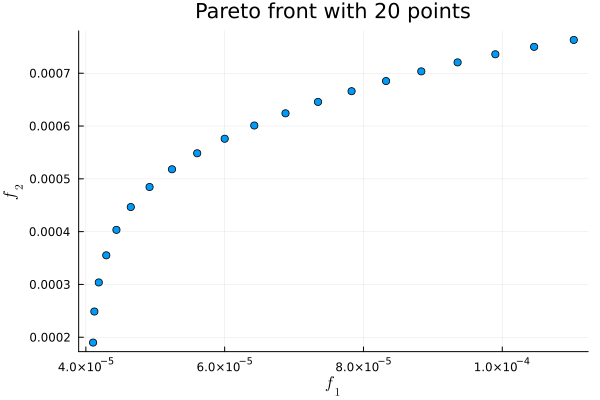

In [6]:
pltnbi = Plots.plot(md)
